# 천안시 복지시설(관내) 인프라 데이터 분석

- 모든 분야 복지시설 증감 추세
- 복지시설별 전국 평균과 천안시 비교, 노인 복지 관련 복지시설이 차지하는 비중
- 천안시 지도 위에 heatmap 시각화를 통해 복지 시설 분포도 파악
- 행정동 별 노인 인구 ~ 만명당 복지시설 수 시각화
- 복지시설 접근성 분석(노인복지시설까지 평균 이동거리, GIS 분석)
- 노인 주택･공공임대주택 분포와 고령자 밀집도 비교

## 2024 전국 노인복지시설 현황

1. 주거 기능을 수행하는 노인주거복지시설(양로시설, 노인공동생활가정, 노인복지주택)

    이용 노인 수 **소폭 증가**
    > 2022년 1만 9,355명 → 2023년 1만 9,369명

    시설 수 **감소**
    > 2022년 308개 → 2023년 297개

2. 노인성 질환(치매·중풍 포함) 등으로 인해 도움이 필요한 노인의 요양 기능을 수행하는 노인의료복지시설(노인요양시설, 노인요양공동생활가정)

    이용 노인 수 **4.62% 증가**
    > 2022년 23만 2,235명 → 2023년 24만 2,974명

    시설 수 **70개소 증가**
    > 2022년 6,069개소 → 2023년 6,139개소

3. 건강한 노인들이 취미생활을 위하여 이용하는 노인여가복지시설인 노인복지관, 경로당, 노인 교실 등

    시설 수 **669개소 증가**
    > 2022년도 6만 9,786개소 → 2023년 7만 455개소

4. 가정에서 일상생활을 영위하면서 신체적·정신적 장애로 어려움을 겪고 있는 노인 등을 방문하여 목욕, 식사 등을 제공하는 재가서비스

    이용 노인 수 **17.02% 증가**
    > 2022년 10만 6.857명 → 2023년 12만 5,048명

    시설 수 **2,624개소 증가**
    > 2022년도 1만 3,272개소 → 2023년 1만 5,896개소

출처 : https://www.mohw.go.kr/board.es?mid=a10503010100&bid=0027&act=view&list_no=1482103&tag=&nPage=1


## 장기요양기관 현황

데이터출처 : KOSIS 시·군·구별 급여종류별 장기요양기관 현황

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Colab 환경에서 한글 깨짐 방지를 위해 폰트를 설치합니다.
# 이미 설치되어 있다면 건너뛸 수 있습니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (24.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126281 files and direc

In [ ]:
# Matplotlib에 나눔바른고딕 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

### 전처리

In [ ]:
# CSV 파일 읽기
df = pd.read_csv('/content/drive/MyDrive/ESAA OB 2조/방학 프로젝트/데이터/시·군·구별_급여종류별_장기요양기관_현황.csv', encoding='UTF-8')

# 천안시, 천안시동남구, 천안시서북구 행의 인덱스 찾기
cheonan_idx = df[(df['시·군·구별(1)'] == '충남') & (df['시·군·구별(2)'] == '천안시')].index
dongnam_idx = df[(df['시·군·구별(1)'] == '충남') & (df['시·군·구별(2)'] == '천안시동남구')].index
seobuk_idx = df[(df['시·군·구별(1)'] == '충남') & (df['시·군·구별(2)'] == '천안시서북구')].index

# 천안시 행이 존재하고, 동남구와 서북구 행이 모두 존재하는 경우에만 처리
if len(cheonan_idx) > 0 and len(dongnam_idx) > 0 and len(seobuk_idx) > 0:
    cheonan_row = cheonan_idx[0]
    dongnam_row = dongnam_idx[0]
    seobuk_row = seobuk_idx[0]

    # 천안시 행에서 '-' 또는 빈 값인 컬럼들을 찾아서 동남구+서북구 값으로 채우기
    for col in df.columns:
        if col not in ['시·군·구별(1)', '시·군·구별(2)']:  # 지역명 컬럼은 제외
            cheonan_val = df.loc[cheonan_row, col]
            dongnam_val = df.loc[dongnam_row, col]
            seobuk_val = df.loc[seobuk_row, col]

            # 천안시 데이터가 비어있거나 '-'인 경우
            if pd.isna(cheonan_val) or cheonan_val == '-' or cheonan_val == '':
                # 동남구와 서북구 값이 모두 숫자인 경우 합계 계산
                try:
                    dongnam_num = float(dongnam_val) if dongnam_val not in ['-', '', np.nan] and pd.notna(dongnam_val) else 0
                    seobuk_num = float(seobuk_val) if seobuk_val not in ['-', '', np.nan] and pd.notna(seobuk_val) else 0

                    # 두 값 모두 0이 아닌 경우에만 합계를 계산
                    if dongnam_num != 0 or seobuk_num != 0:
                        df.loc[cheonan_row, col] = int(dongnam_num + seobuk_num)
                except (ValueError, TypeError):
                    # 숫자로 변환할 수 없는 경우 그대로 유지
                    continue

    # 동남구와 서북구 행 삭제
    df = df.drop([dongnam_row, seobuk_row])

    # 인덱스 재설정
    df = df.reset_index(drop=True)

    # 결과 확인
    cheonan_result = df[(df['시·군·구별(1)'] == '충남') & (df['시·군·구별(2)'] == '천안시')]

    # 컬럼명에서 연도 뒤의 ".숫자" 제거
    df.columns = [
        col.split('.')[0] if col not in ['시·군·구별(1)', '시·군·구별(2)'] else col
        for col in df.columns
    ]

    # 결과를 새 파일로 저장
    df.to_csv('processed_data.csv', index=False, encoding='utf-8-sig')

else:
    print("천안시, 천안시동남구, 천안시서북구 행을 모두 찾을 수 없습니다.")
    print("데이터를 확인해 주세요.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# -------------------------
# 1. 데이터 불러오기 및 컬럼 평탄화
# -------------------------
# 파일 읽기
df = pd.read_csv('processed_data.csv',
    header=[0, 1, 2], encoding='utf-8'
)

# 0행 제거
df = df.drop(index=0).reset_index(drop=True)

# MultiIndex 컬럼을 연도_대분류_소분류 형태로 평탄화
df.columns = ['_'.join([str(x) for x in col if x]) for col in df.columns]

df

,시·군·구별(1)_시·군·구별(1)_시·군·구별(1),시·군·구별(2)_시·군·구별(2)_시·군·구별(2),2010_재가_방문요양,2010_재가_방문목욕,2010_재가_방문간호,2010_재가_주야간보호,2010_재가_단기보호,2010_재가_복지용구,2010_노인의료복지시설_노인요양시설,2010_노인의료복지시설_노인전문요양시설,...,2023_재가노인복지시설_단기보호,2023_재가노인복지시설_복지용구,2023_재가장기요양기관_방문요양,2023_재가장기요양기관_방문목욕,2023_재가장기요양기관_방문간호,2023_재가장기요양기관_주야간보호,2023_재가장기요양기관_단기보호,2023_재가장기요양기관_복지용구,2023_노인의료복지시설_노인요양시설,2023_노인의료복지시설_노인요양공동생활가정
0,합계,소계,9164,7294,739,1273,199,1278,1078,450,...,70,560,10011,7562,516,1714,38,1511,4568,1701
1,충남,천안시,64,54,4,14,2,14,8,5,...,2,6,71,53,6,28,-,19,63,23


In [ ]:
# 연도 컬럼만 추출
year_cols = [col for col in df.columns if col.startswith('20')]

# melt로 데이터 변형
df_melt = df.melt(
    id_vars=['시·군·구별(1)_시·군·구별(1)_시·군·구별(1)', '시·군·구별(2)_시·군·구별(2)_시·군·구별(2)'],
    value_vars=year_cols,
    var_name='연도_시설',
    value_name='시설수'
)

# 연도와 시설유형 분리
df_melt['연도'] = df_melt['연도_시설'].str.slice(0, 4).astype(int)
df_melt['시설유형'] = df_melt['연도_시설'].str.slice(5)

# 시설수 숫자형 변환 (결측치는 0으로 처리)
df_melt['시설수'] = pd.to_numeric(df_melt['시설수'], errors='coerce').fillna(0).astype(int)

# 컬럼 이름 정리
df_melt.rename(columns={
    '시·군·구별(1)_시·군·구별(1)_시·군·구별(1)': '시도',
    '시·군·구별(2)_시·군·구별(2)_시·군·구별(2)': '시군구'
}, inplace=True)

# 데이터 확인
print(df_melt.head())

   시도  시군구         연도_시설   시설수    연도     시설유형
0  합계   소계  2010_재가_방문요양  9164  2010  재가_방문요양
1  충남  천안시  2010_재가_방문요양    64  2010  재가_방문요양
2  합계   소계  2010_재가_방문목욕  7294  2010  재가_방문목욕
3  충남  천안시  2010_재가_방문목욕    54  2010  재가_방문목욕
4  합계   소계  2010_재가_방문간호   739  2010  재가_방문간호


### 1. 전국 복지 시설 증감 추세

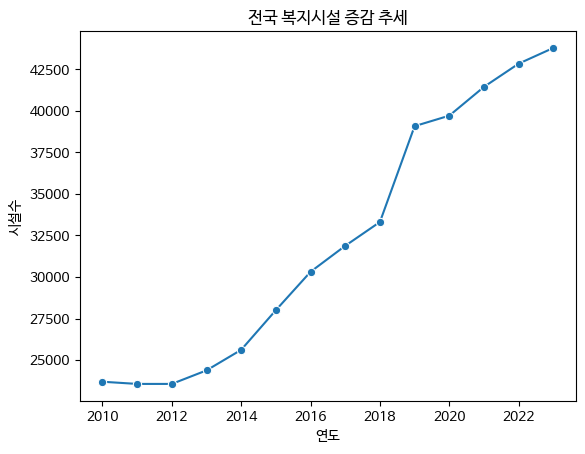

In [ ]:
national_df = df_melt[df_melt['시도'] == '합계']
national_total = national_df.groupby('연도')['시설수'].sum().reset_index()

sns.lineplot(data=national_total, x='연도', y='시설수', marker='o')
plt.title('전국 복지시설 증감 추세')
plt.show()

### 2. 천안시 복지 시설 증감 추세

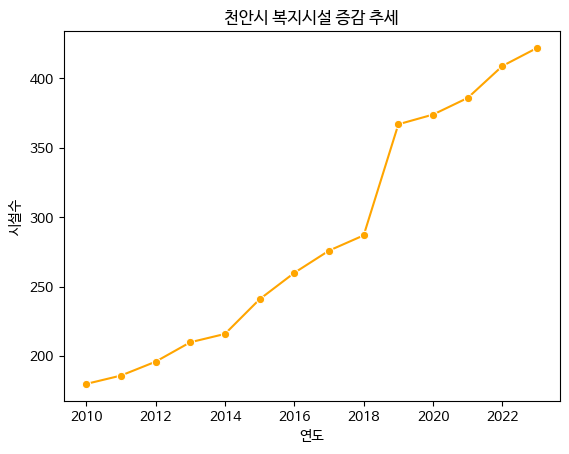

In [ ]:
cheonan_df = df_melt[df_melt['시군구'] == '천안시']
cheonan_total = cheonan_df.groupby('연도')['시설수'].sum().reset_index()

sns.lineplot(data=cheonan_total, x='연도', y='시설수', marker='o', color='orange')
plt.title('천안시 복지시설 증감 추세')
plt.show()

### 3. 복지시설별 전국과 천안시 비교

In [ ]:
# 천안시/전국 구분된 데이터 생성
national_grouped = df_melt[df_melt['시군구'] != '천안시'].groupby(['연도', '시설유형'], as_index=False).agg({'시설수': 'sum'})
cheonan_grouped = df_melt[df_melt['시군구'] == '천안시'].groupby(['연도', '시설유형'], as_index=False).agg({'시설수': 'sum'})

# 병합: 전국 + 천안
data_merged = pd.merge(
    national_grouped, cheonan_grouped,
    on=['연도', '시설유형'],
    how='left',
    suffixes=('_전국', '_천안')
)

# NaN → 0 처리
data_merged['시설수_천안'] = data_merged['시설수_천안'].fillna(0)

# 천안 비율 계산
data_merged['천안_비율(%)'] = (data_merged['시설수_천안'] / data_merged['시설수_전국']) * 100

# 2023년 필터링
data_2023 = data_merged[data_merged['연도'] == 2023].copy()
national_2023 = national_grouped[national_grouped['연도'] == 2023].copy()
cheonan_2023 = cheonan_grouped[cheonan_grouped['연도'] == 2023].copy()

/tmp/ipython-input-50-2670655831.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-50-2670655831.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-50-2670655831.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


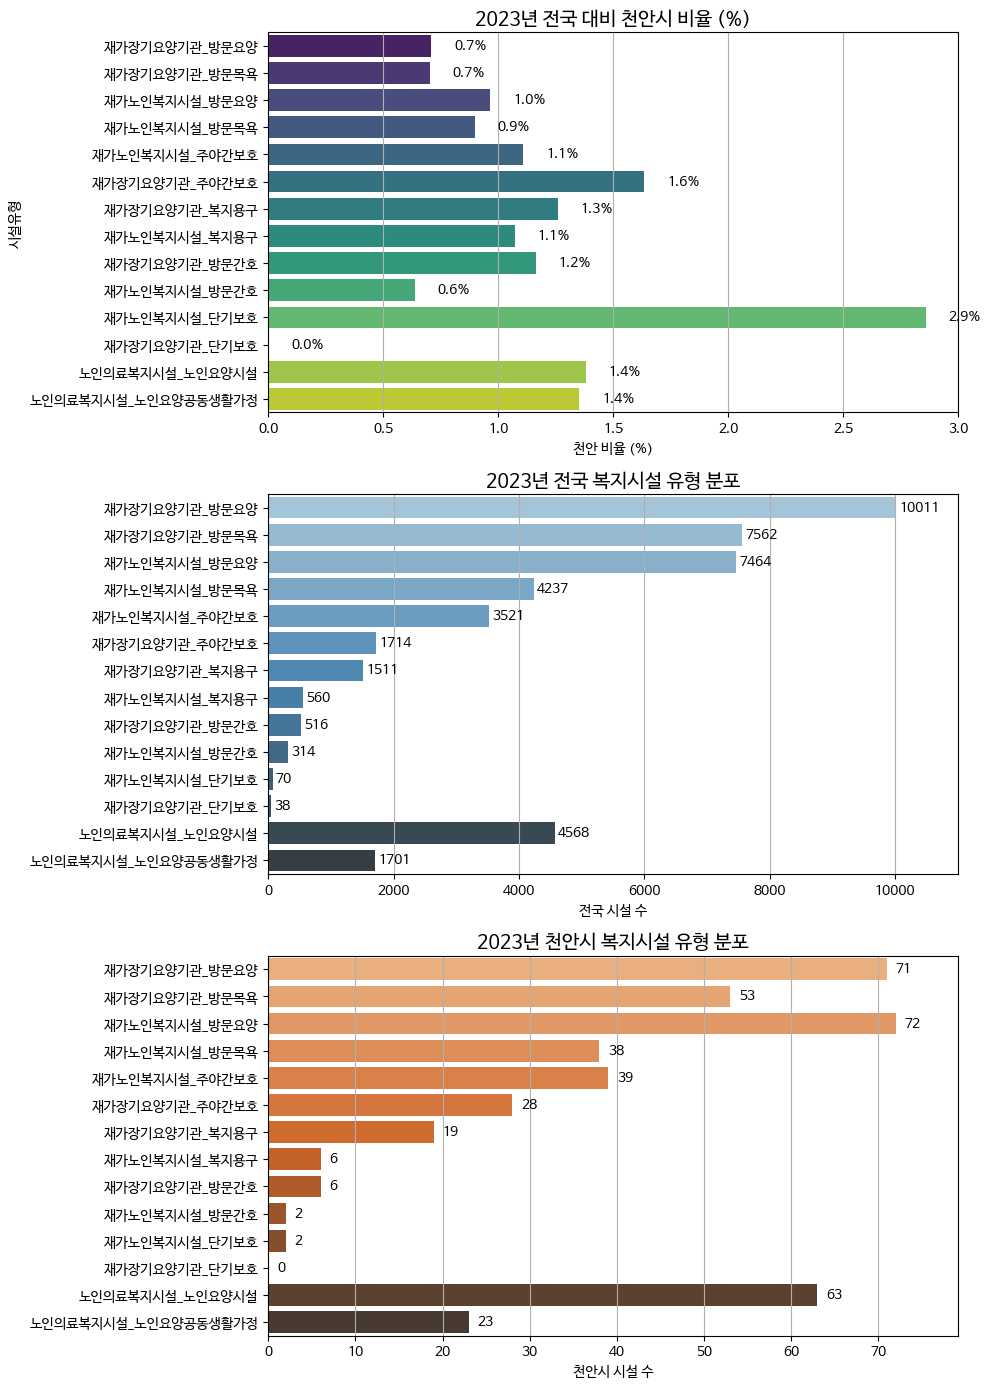

In [ ]:
# 정렬 기준 키워드
priority_keywords = ['재가', '재가노인복지시설', '재가장기요양기관', '노인의료복지시설']

# 기존 시설유형 리스트
all_facilities = national_grouped[national_grouped['연도'] == 2023].sort_values('시설수', ascending=False)['시설유형'].tolist()

# 키워드 우선 정렬 함수
def facility_sort_key(name):
    for i, keyword in enumerate(priority_keywords):
        if name.startswith(keyword):
            return i
    return len(priority_keywords) + all_facilities.index(name)

# 최종 정렬 순서
facility_order = sorted(all_facilities, key=facility_sort_key)

# 카테고리형으로 변환 (순서 지정)
for df in [data_2023, national_2023, cheonan_2023]:
    df['시설유형'] = pd.Categorical(df['시설유형'], categories=facility_order, ordered=True)

# 최대 x축 값 (전체 그래프의 기준으로 사용)
max_x = max(national_2023['시설수'].max(), cheonan_2023['시설수'].max())

# 그래프 설정
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 14), sharey=True)

# (1) 천안 비율
sns.barplot(
    data=data_2023,
    x='천안_비율(%)',
    y='시설유형',
    palette='viridis',
    dodge=False,
    ax=axes[0],
)
axes[0].set_title('2023년 전국 대비 천안시 비율 (%)', fontsize=14)
axes[0].set_xlabel('천안 비율 (%)')
axes[0].set_ylabel('시설유형')
axes[0].grid(axis='x')

# 텍스트 표시
for patch in axes[0].patches:
    width = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    axes[0].text(
        width + 0.1, y,
        f"{width:.1f}%",
        va='center'
    )

# (2) 전국 시설유형 분포
sns.barplot(
    data=national_2023,
    x='시설수',
    y='시설유형',
    palette='Blues_d',
    dodge=False,
    ax=axes[1]
)
axes[1].set_title('2023년 전국 복지시설 유형 분포', fontsize=14)
axes[1].set_xlabel('전국 시설 수')
axes[1].set_ylabel('')
axes[1].set_xlim(0, max_x * 1.1)
axes[1].grid(axis='x')

for patch in axes[1].patches:
    width = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    axes[1].text(
        width + 50, y,
        f"{int(width)}",
        va='center'
    )

# (3) 천안시 시설유형 분포
sns.barplot(
    data=cheonan_2023,
    x='시설수',
    y='시설유형',
    palette='Oranges_d',
    dodge=False,
    ax=axes[2]
)
axes[2].set_title('2023년 천안시 복지시설 유형 분포', fontsize=14)
axes[2].set_xlabel('천안시 시설 수')
axes[2].set_ylabel('')
max_x_cheonan = cheonan_2023['시설수'].max()
axes[2].set_xlim(0, max_x_cheonan * 1.1)
axes[2].grid(axis='x')

for patch in axes[2].patches:
    width = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    axes[2].text(
        width + 1, y,
        f"{int(width)}",
        va='center'
    )

plt.tight_layout()
plt.show()

1. 전국과 천안시 증감 추세 비교

    2023년 기준 천안시 복지시설 수 약 420개

    > 2010년 대비 2.3배 이상 증가

    전국적인 증가 추세와 유사하게 나타남

2. 천안시 복지시설 특징

   재가요양중심 복지 모델에 강점을 보임

    단기보호, 복지구, 방문목욕 등 일부 유형이 매우 적음




## 크롤링

### 라이브러리 설치, 불러오기

In [ ]:
# 설치
!pip install geopandas selenium beautifulsoup4 osmnx folium
!pip install fiona
!pip install selenium

In [ ]:
# 라이브러리 import
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from selenium import webdriver
from bs4 import BeautifulSoup
import folium

### 행정동 중심 좌표 확보

http://www.gisdeveloper.co.kr/?p=2332

geoservice를 이용한 천안시 행정동 중심 좌표 데이터 추출

코드 : 시도(44), 시군구(133), 읍면동(256)

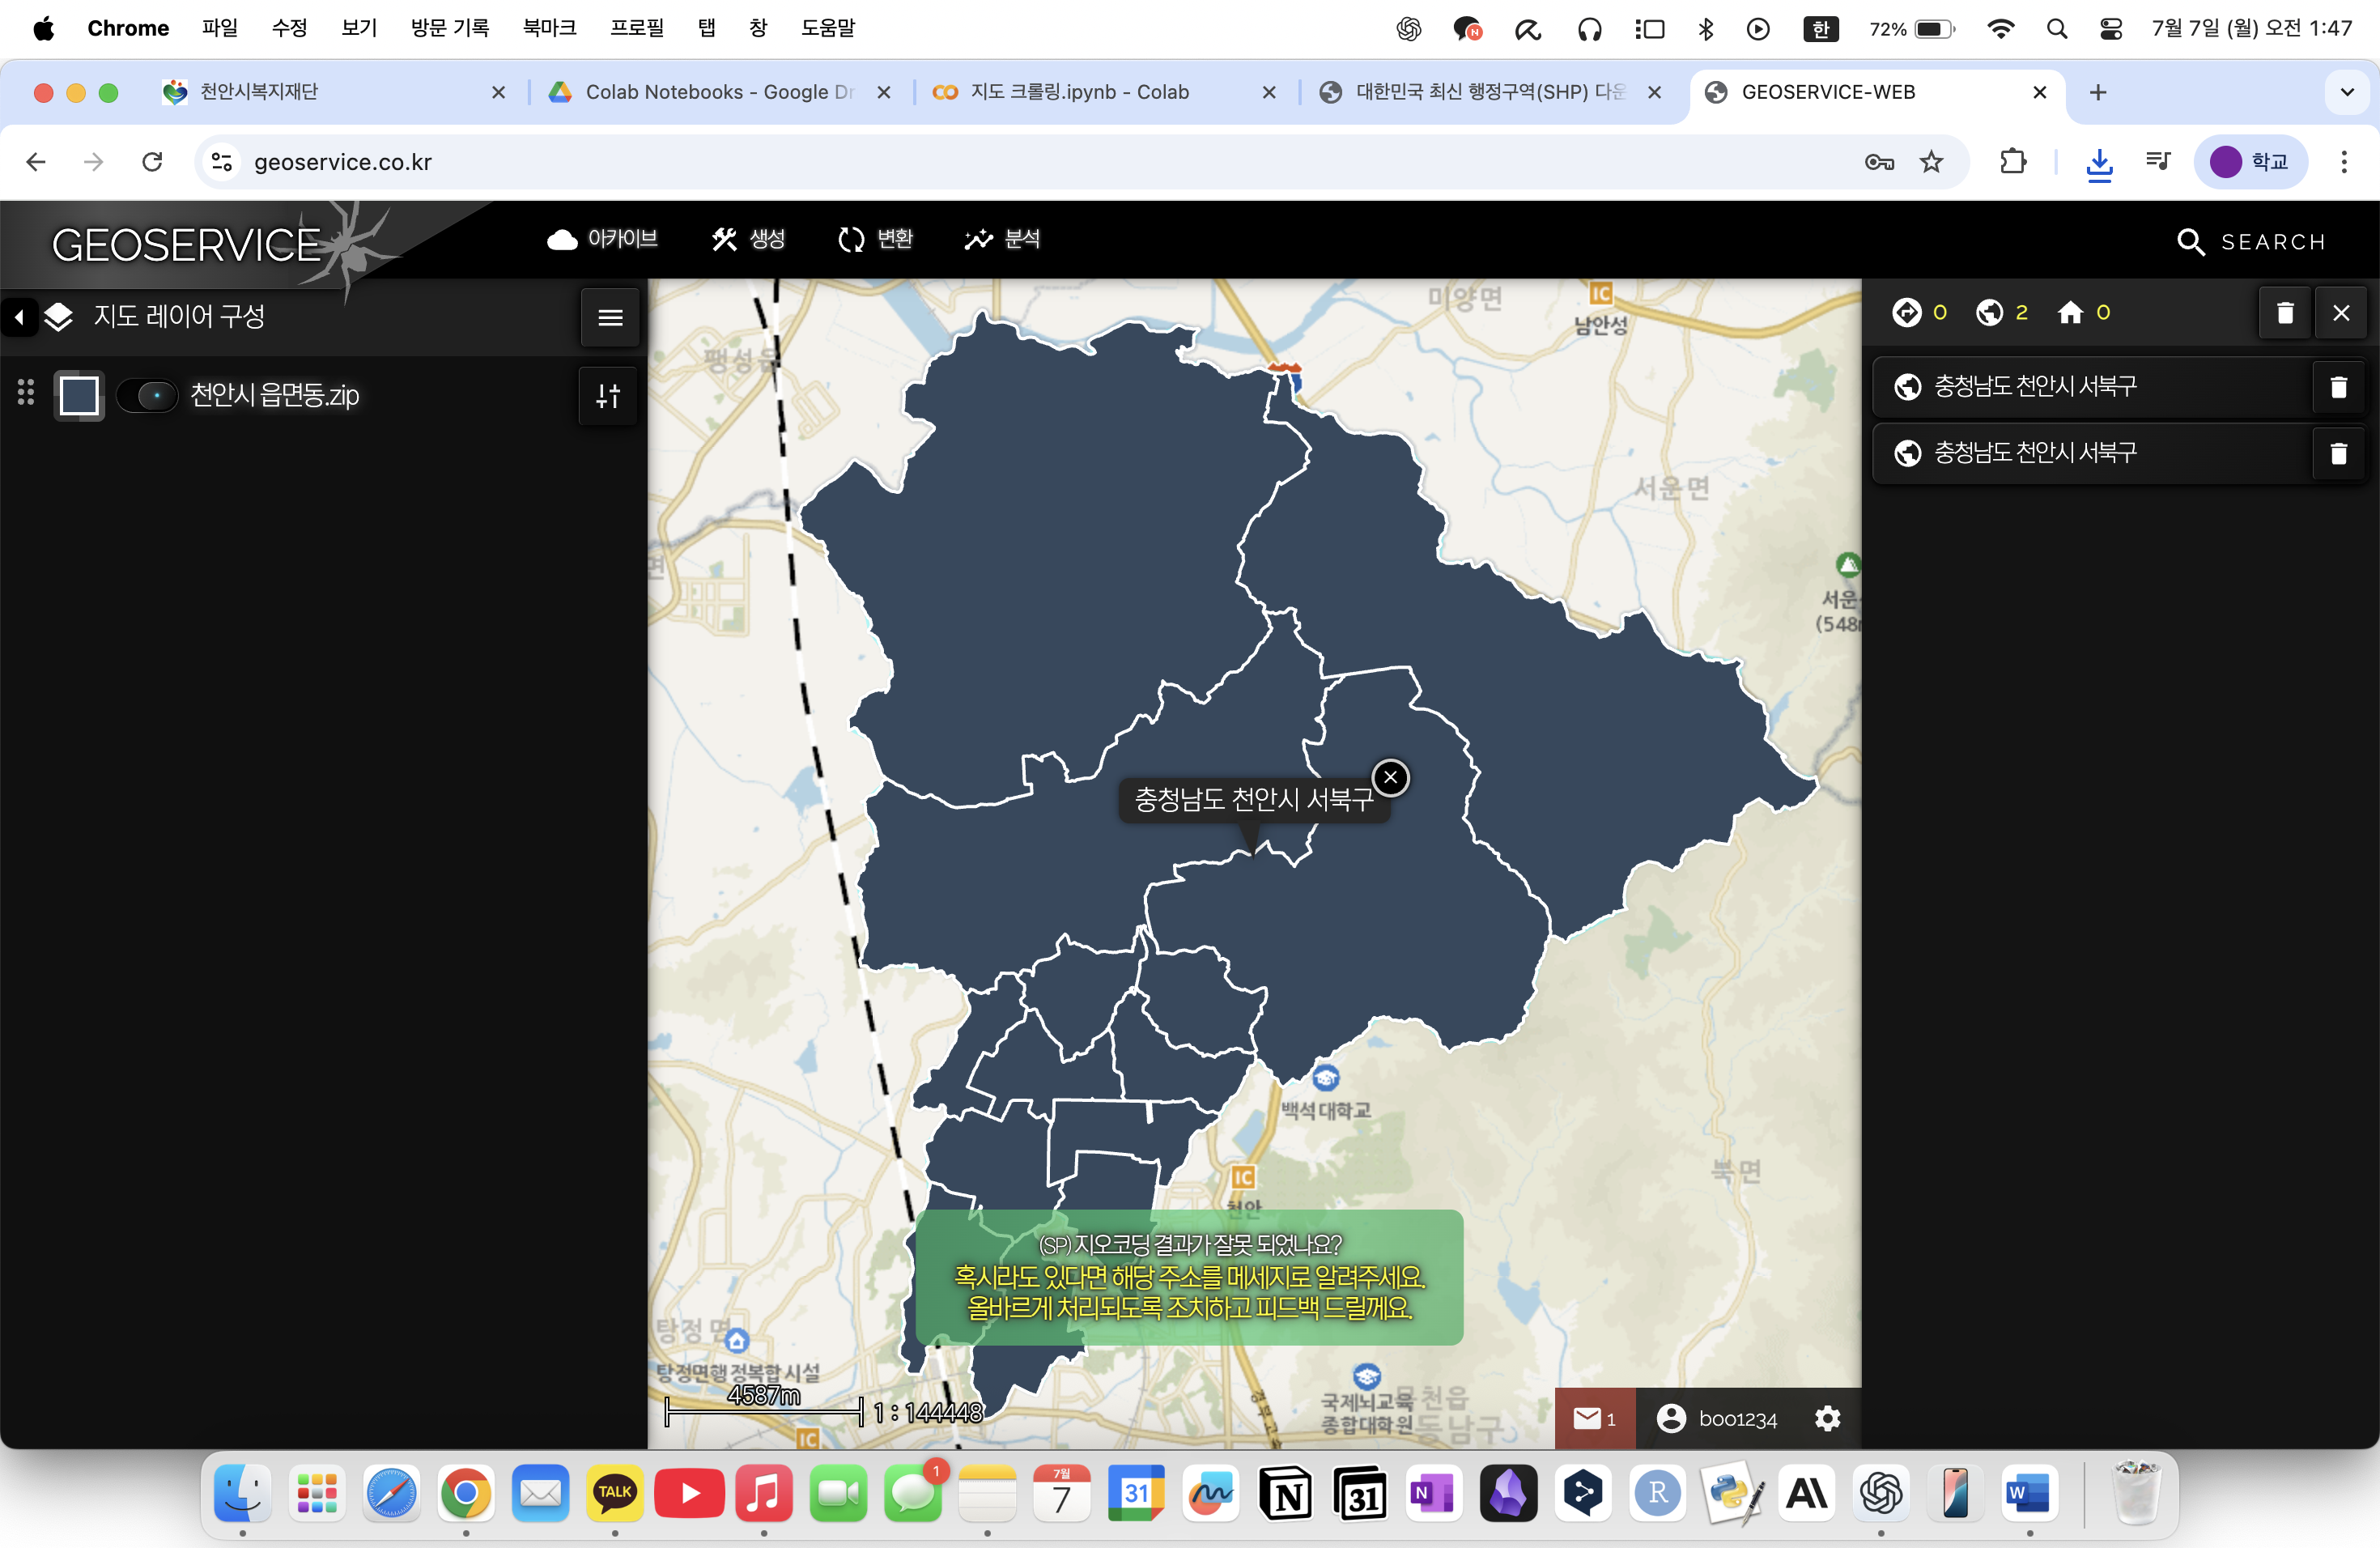

### 읍면동 중심좌표 불러오기

geoservice에서 추출하면 **shapefile** 형태로 제공해줌

<shp 파일>

GIS(지리정보체계) 데이터의 독자적인 확장자

여러 개의 파일이 한 묶음으로 저장되어 있음
> shp 파일 포함 최소 3개 존재해야함

**모든 파일의 파일명이 동일해야 함**

[필수 확장자]
- **shp** : Shape File - GIS에 올리는 파일
- **dbf** : DataBase file : 데이터가 들어있는 파일
- **shx** : Index File : 인덱스 파일, 직접 다루는 일은 거의 없음

[기타 확장자]
- **prj** : Projection File - 좌표계 파일
- **cpg** : Encoding File = 언어 인코딩 파일
- sbn & sbx : 공간 인덱스 저장 파일
- xml : shp 파일의 메타 데이터 저장 파일

출처 : https://blog.naver.com/mooming45/223285975205

In [ ]:
import geopandas as gpd

gpd.options.io_engine = "fiona"  # 강제로 fiona 사용

shapefile_path = "/content/drive/MyDrive/ESAA OB 2조/방학 프로젝트/데이터/천안시_GIS_데이터/a.shp"
dong_gdf = gpd.read_file(shapefile_path)

# invalid geometry가 있으면 buffer(0)로 고치기
dong_gdf['geometry'] = dong_gdf['geometry'].buffer(0)

print(dong_gdf.head())

     EMD_CD       EMD_ENG_NM EMD_KOR_NM  \
0  44133101      Wachon-dong        와촌동   
1  44133102  Seongjeong-dong        성정동   
2  44133103    Baekseok-dong        백석동   
3  44133104     Dujeong-dong        두정동   
4  44133105  Seongseong-dong        성성동   

                                            geometry  
0  POLYGON ((968569.82 1868327.784, 968562.997 18...  
1  POLYGON ((968861.628 1870013.559, 968860.968 1...  
2  POLYGON ((965336.42 1869364.007, 965337.898 18...  
3  POLYGON ((968212.833 1871254.615, 968237.105 1...  
4  POLYGON ((967902.672 1872631.857, 967906.216 1...  


In [ ]:
import geopandas as gpd

gpd.options.io_engine = "fiona"  # 강제로 fiona 사용

shapefile_path = "/content/drive/MyDrive/ESAA OB 2조/방학 프로젝트/데이터/천안시_GIS_데이터/a.shp"
dong_gdf = gpd.read_file(shapefile_path)

# 중심좌표 계산
dong_gdf['centroid'] = dong_gdf.geometry.centroid

# 중심좌표에서 경도/위도 추출
dong_gdf['centroid_x'] = dong_gdf['centroid'].x
dong_gdf['centroid_y'] = dong_gdf['centroid'].y

print(dong_gdf[['centroid_x', 'centroid_y']].head())

      centroid_x    centroid_y
0  968315.553646  1.867846e+06
1  967937.570172  1.869260e+06
2  965792.251361  1.870009e+06
3  968193.159062  1.870642e+06
4  966701.268750  1.871820e+06


## 노인복지시설 좌표 크롤링(Selenium 이용)

In [ ]:
!pip install selenium

### 시설명 & 상세 주소 크롤링

In [ ]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Selenium 설정
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(options=options)

# 1) 사이트 접속 & '노인복지' 버튼 클릭
driver.get('https://www.cawf.or.kr/map/map2.php')

try:
    btn = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//a[contains(@href,'part=노인복지')]"))
    )
    btn.click()
    time.sleep(2)  # 로딩 대기
except Exception as e:
    print("노인복지 버튼 클릭 실패:", e)

# 2) 1~15 페이지 순회
results = []

for page_num in range(1, 16):  # 페이지 1~15
    page_url = f"https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage={page_num}"
    print(f"[{page_num}/15] 페이지 크롤링: {page_url}")

    driver.get(page_url)
    time.sleep(1.5)  # 로딩 대기

    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    lis = soup.find_all('li')
    for li in lis:
        name_tag = li.find('div', class_='name')
        addr_tag = li.find('dt', text='주소')
        addr_value = addr_tag.find_next_sibling('dd').get_text(strip=True) if addr_tag else None

        if name_tag and addr_value:
            name = name_tag.find('strong').get_text(strip=True)
            results.append({'name': name, 'address': addr_value})

print(f"총 {len(results)} 개의 시설 크롤링 완료")

# 3) DataFrame & 저장
df_crol = pd.DataFrame(results)
print(df)

df_crol.to_csv('welfare_facilities.csv', index=False, encoding='utf-8-sig')
print("CSV 파일로 저장 완료: welfare_facilities.csv")

driver.quit()

[1/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=1


/tmp/ipython-input-56-2498325582.py:45: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  addr_tag = li.find('dt', text='주소')


[2/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=2
[3/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=3
[4/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=4
[5/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=5
[6/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=6
[7/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=7
[8/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=8
[9/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=9
[10/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=10
[11/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=11
[12/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=12
[13/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=13
[14/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=14
[15/15] 페이지 크롤링: https://www.cawf.or.kr/map/map2.php?part=노인복지&cpage=15
총 132 개의

### 카카오 API로 시설명 -> 위경도 변환

In [ ]:
import pandas as pd
import requests
import time

# 1) DataFrame 불러오기
df_crol = pd.read_csv('welfare_facilities.csv')

# 2) 카카오 API 설정
REST_API_KEY = "498d899fd084b23f98e07886d41630fc"
KAKAO_LOCAL_API_URL = "https://dapi.kakao.com/v2/local/search/address.json"

headers = {
    "Authorization": f"KakaoAK {REST_API_KEY}"
}

def get_coords(address):
    """주소로 위도, 경도 반환 함수"""
    params = {"query": address}
    try:
        response = requests.get(KAKAO_LOCAL_API_URL, headers=headers, params=params)
        result = response.json()
        if response.status_code == 200 and result['documents']:
            doc = result['documents'][0]
            return float(doc['y']), float(doc['x'])  # y=위도, x=경도
        else:
            return None, None
    except Exception as e:
        print(f"Error for address {address}: {e}")
        return None, None

# 3) 주소별 위경도 얻기
latitudes = []
longitudes = []

for addr in df_crol['address']:
    lat, lng = get_coords(addr)
    latitudes.append(lat)
    longitudes.append(lng)
    time.sleep(0.3)  # API 호출 제한을 고려한 딜레이 (필요 시 조절)

# 4) DataFrame에 위경도 컬럼 추가
df_crol['latitude'] = latitudes
df_crol['longitude'] = longitudes

# 5) 결과 CSV 저장
df_crol.to_csv('welfare_facilities_with_coords.csv', index=False, encoding='utf-8-sig')

print("위경도 추출 및 저장 완료")

위경도 추출 및 저장 완료


## 도보 10분 커버리지 분석

### 도보 10분 거리 도달 가능 영역 생성

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import folium

df_loc = pd.read_csv('welfare_facilities_with_coords.csv')

# latitude → y, longitude → x 로 컬럼 이름 변경
df_loc.rename(columns={'latitude':'y', 'longitude':'x'}, inplace=True)

# 좌표가 없는 행 제거
df_loc = df_loc.dropna(subset=['x', 'y'])

# 도보 10분 거리 도달 가능 영역 생성
# 시설 좌표 → Point
geometry = [Point(xy) for xy in zip(df_loc['x'], df_loc['y'])]
gdf = gpd.GeoDataFrame(df_loc, geometry=geometry, crs='EPSG:4326')

# UTM으로 변환 (충청남도 천안시 기준: 52N -> EPSG: 32652)
gdf_utm = gdf.to_crs(epsg=32652)

# 도보 10분 ≈ 반경 약 700m 버퍼
gdf_utm['buffer'] = gdf_utm.geometry.buffer(700)

# 다시 WGS84로 (folium 시각화용)
gdf_buffer = gdf_utm.set_geometry('buffer').to_crs(epsg=4326)

### 행정동별 커버리지 계산

위에서 생성한 각 복지시설에서 도보 10분 버퍼(반경 700m 원)와 행정동의 경계와 버퍼들이 얼마나 겹치는지 계산

겹치는 면적 / 행정동 전체 면적 = 커버리지 비율

•	행정동 전체 중에서 도보 10분 이내에 복지시설이 있는 면적이 차지하는 비율

•	커버리지 0%에 가까우면 → 그 행정동 안에는 도보 10분 이내에 복지시설이 거의 없음

•	커버리지 100%에 가까우면 → 그 행정동 면적 전체가 도보 10분 이내 복지시설로 커버됨

In [ ]:
# 행정동도 UTM으로 변환
dong_gdf_utm = dong_gdf.to_crs(epsg=32652)

# 행정동별 전체 면적
dong_gdf_utm['area'] = dong_gdf_utm.geometry.area

# 각 행정동과 시설 버퍼의 교집합
coverage = []
for idx, dong in dong_gdf_utm.iterrows():
    covered_area = 0
    for _, buf in gdf_utm.iterrows():
        inter = dong.geometry.intersection(buf['buffer'])
        covered_area += inter.area if not inter.is_empty else 0
    coverage_ratio = covered_area / dong['area']
    coverage.append(coverage_ratio)

dong_gdf_utm['coverage_ratio'] = coverage

print(dong_gdf_utm[['coverage_ratio']])

    coverage_ratio
0         3.424024
1         3.846558
2         1.990830
3         3.427948
4         0.389333
5         0.000000
6         3.764584
7         1.586750
8         0.140649
9         1.072083
10        0.854596
11        0.407746
12        0.218403
13        0.277301
14        0.179552


### 외곽·산간 지역 탐색

In [ ]:
poor_coverage = dong_gdf_utm[dong_gdf_utm['coverage_ratio'] < 0.1]
print(poor_coverage)

     EMD_CD  EMD_ENG_NM EMD_KOR_NM  \
5  44133106  Chaam-dong        차암동   

                                            geometry  \
5  POLYGON ((331499.263 4080696.733, 331500.297 4...   

                         centroid     centroid_x    centroid_y          area  \
5  POINT (965341.038 1872231.798)  965341.038343  1.872232e+06  2.468857e+06   

   coverage_ratio  
5             0.0  


## folium으로 지도 시각화

In [ ]:
# 중심 좌표는 천안 대략
m = folium.Map(location=[36.8,127.1], zoom_start=12)

# 시설 버퍼 (파란색 반투명 원)
for _, row in gdf_buffer.iterrows():
    folium.GeoJson(row['buffer'].__geo_interface__,
                   tooltip=row['name'],
                   style_function=lambda x: {
                       'fillColor': 'blue', 'color': 'blue',
                       'fillOpacity': 0.2, 'weight': 1
                   }).add_to(m)

# 시설 마커
for _, row in df_loc.iterrows():
    folium.Marker(location=[row['y'], row['x']],
                  popup=row['name'],
                  icon=folium.Icon(color='blue')).add_to(m)

# 커버리지 낮은 행정동 폴리곤 (붉은색 강조)
poor_coverage = poor_coverage.to_crs(epsg=4326)
for _, row in poor_coverage.iterrows():
    folium.GeoJson(row['geometry'].__geo_interface__,
                   tooltip=f"{row['EMD_KOR_NM']} (커버리지 {row['coverage_ratio']:.1%})",
                   style_function=lambda x: {
                       'fillColor': 'red', 'color': 'red',
                       'fillOpacity': 0.3, 'weight': 1
                   }).add_to(m)

# 지도 저장
m.save('welfare_coverage_map.html')
print("지도 저장 완료: welfare_coverage_map.html")

지도 저장 완료: welfare_coverage_map.html


In [ ]:
from IPython.display import display

display(m)

## 천안시 지도 위에 복지 시설 분포 Heatmap

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

df_loc = pd.read_csv('welfare_facilities_with_coords.csv')

# latitude → y, longitude → x 로 컬럼 이름 변경
df_loc.rename(columns={'latitude':'y', 'longitude':'x'}, inplace=True)

# 좌표가 없는 행 제거
df_loc = df_loc.dropna(subset=['x', 'y'])

# 지도 초기화 (천안시 중심 좌표)
m = folium.Map(location=[36.8151, 127.1139], zoom_start=11)

# Heatmap 추가
heat_data = [[row['y'], row['x']] for index, row in df_loc.iterrows()]
HeatMap(heat_data, radius=12).add_to(m)

m.save('cheonan_facilities_heatmap.html')

In [ ]:
m

## 생각 정리

일단 전국적으로도 천안시 내에서도 시설 수 증가, 노인 인구 수 증가함

> 고령화가 진행됨에 따라 수요가 증가하고 있음을 확인할 수 있음

천안시의 경우 재가요양중심 복지 모델에 강점을 보임

그러나 복지시설 다양성에서는 부족한 것 같음

> 강점을 더 살리는 정책 제안을 할지, 약점인 다양성을 높일 수 있는 정책 제안을 할지 고민해봐야 할 것 같음, 근데 다양성을 보자면 전국적으로 비슷한 분포를 보이는거 같긴함 적은데에는 이유가 있는가...?

도보 커버리지에 빨간색 부분 존재 -> 시설이 없음

노인 인구 데이터를 찾아서 노인 거주 현황도 시각화 같이 진행하면 더 의미있는 제안을 도출해낼 수 있을 것 같음

지도상에서 숲? 산? 같은게 많이 보임 -> 찾아보니까 '중앙을 남북으로 가로 지르는 차령산맥의 태조산 줄기를 중심으로 동쪽과 서쪽으로 지역이 분리'([출처] 한국학중앙연구원 - 향토문화전자대전) 되어 있다고 하네요

> 이러한 지리적 특성으로 인해 이동에 어려움을 겪는건 없을지.. 만약 있다면 이분들을 위한 정책 제안도 메리트 있을 듯 합니다